In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
import zipfile
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn import set_config
from sklearn.preprocessing import RobustScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

# Create API connection to Kaggle

In [2]:
# Create kaggle directory
os.makedirs(os.path.expanduser("~/.kaggle"),exist_ok=True)
# Set permissions(required by kaggle api)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"),0o600)

## Test the connection to Kaggle before loading the data

In [3]:
api = KaggleApi()
api.authenticate()

# Test with a simple call
datasets = api.dataset_list(search='titanic')
for d in datasets[:3]:
    print(d.ref, "-", d.title)

heptapod/titanic - Titanic
brendan45774/test-file - Titanic dataset
yasserh/titanic-dataset - Titanic Dataset


# Create a method that downloads and loads the data into a dataframe

In [4]:
def load_housing_data():
    dataset_path=Path("/Users/luthfi/sandbox/Kaggle_competitions/Machine_learning/textbook/sandbox/datasets/Real%20estate.csv")
    Path("datasets").mkdir(parents=True,exist_ok=True)

    if not dataset_path.exists():
        # Authenticate with kaggle api
        api = KaggleApi()
        api.authenticate()

        # Download dataset
        api.dataset_download_file(
            dataset="quantbruce/real-estate-price-prediction",
            file_name="Real estate.csv",
            path="datasets",
            force=True
        )

        # Open the file in the local folder created
        try:
            with open("/Users/luthfi/sandbox/Kaggle_competitions/Machine_learning/textbook/sandbox/datasets/Real%20estate.csv","r") as file:
                content= file.read()
        except FileNotFoundError:
            print("File doesn't exist locally")

    return pd.read_csv(dataset_path)

In [5]:
df = load_housing_data()
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [6]:
df.shape

(414, 8)

# Check for any missing values

In [7]:
df.isnull().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [8]:
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


array([[<Axes: title={'center': 'No'}>,
        <Axes: title={'center': 'X1 transaction date'}>,
        <Axes: title={'center': 'X2 house age'}>],
       [<Axes: title={'center': 'X3 distance to the nearest MRT station'}>,
        <Axes: title={'center': 'X4 number of convenience stores'}>,
        <Axes: title={'center': 'X5 latitude'}>],
       [<Axes: title={'center': 'X6 longitude'}>,
        <Axes: title={'center': 'Y house price of unit area'}>, <Axes: >]],
      dtype=object)

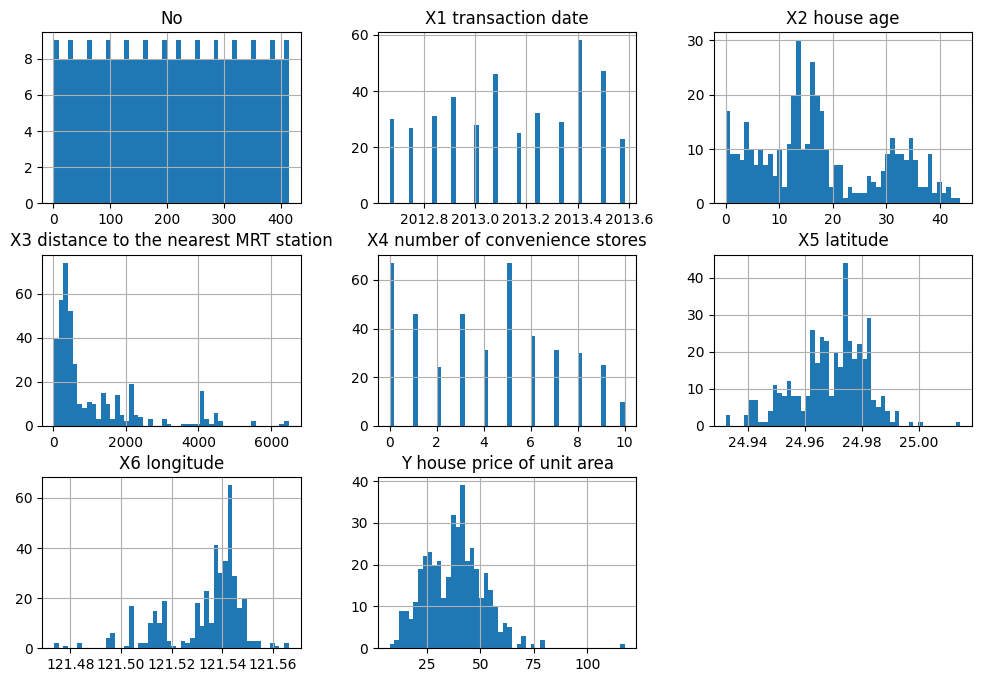

In [9]:
df.hist(bins=50,figsize=(12,8))

In [10]:
df.columns

Index(['No', 'X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

# Split the data

In [11]:
train_set,test_set = train_test_split(df,random_state=42,test_size=0.2)

In [12]:
train_set.shape

(331, 8)

In [13]:
test_set.shape

(83, 8)

# Explore + Visualize the data to gain insights - manually

## Manual Changes

### Change the name so is uniform

In [14]:
manual_train = train_set.copy()

In [15]:
manual_train.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
192,193,2013.167,43.8,57.58945,7,24.96750,121.54069,42.7
234,235,2013.250,8.0,2216.61200,4,24.96007,121.51361,23.9
5,6,2012.667,7.1,2175.03000,3,24.96305,121.51254,32.1
45,46,2013.083,36.6,488.81930,8,24.97015,121.54494,38.3
245,246,2013.417,7.5,639.61980,5,24.97258,121.54814,40.8


In [16]:
manual_train.reset_index(drop=True,inplace=True)
manual_train= manual_train.drop(columns='No')

In [17]:
names = list(manual_train.columns)
names

['X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude',
 'Y house price of unit area']

In [18]:
for i in range(len(names)):
    names[i] = names[i][2:] # This removes the X1
    names[i] = names[i].lstrip() # Removes the from space
print(names)

['transaction date', 'house age', 'distance to the nearest MRT station', 'number of convenience stores', 'latitude', 'longitude', 'house price of unit area']


In [19]:
manual_train.columns = names
manual_train.head()

,transaction date,house age,distance to the nearest MRT station,number of convenience stores,latitude,longitude,house price of unit area
0,2013.167,43.8,57.58945,7,24.96750,121.54069,42.7
1,2013.250,8.0,2216.61200,4,24.96007,121.51361,23.9
2,2012.667,7.1,2175.03000,3,24.96305,121.51254,32.1
3,2013.083,36.6,488.81930,8,24.97015,121.54494,38.3
4,2013.417,7.5,639.61980,5,24.97258,121.54814,40.8


### Transaction date - change so its only contains just the year

In [20]:
manual_train['transaction date'].dtype

dtype('float64')

In [21]:
manual_train['transaction date'] = pd.to_datetime(
    manual_train['transaction date'].astype(int), format='%Y'
).dt.year

In [22]:
manual_train.dtypes

transaction date                         int32
house age                              float64
distance to the nearest MRT station    float64
number of convenience stores             int64
latitude                               float64
longitude                              float64
house price of unit area               float64
dtype: object

In [23]:
manual_train['transaction date']

0      2013
1      2013
2      2012
3      2013
4      2013
       ... 
326    2013
327    2013
328    2013
329    2012
330    2013
Name: transaction date, Length: 331, dtype: int32

### Visualize geographical data

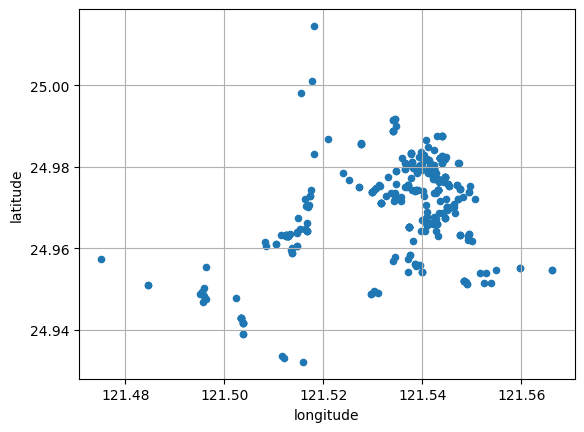

In [24]:
manual_train.plot(kind= "scatter",x="longitude",y="latitude",grid=True)
plt.show()

Density of points:
- When many points overlap, their transparency adds up visually — the more overlap, the darker that region becomes.
- This creates a map of where the houses are. With alpha=0.2:

    Darker areas = more houses listed there

    Lighter/sparse areas = fewer houses
- alpha=0.2 helps you:

    Spot clusters or hot spots where houses are densely located

    Avoid the problem of "overplotting" (when points sit on top of each other and hide information)

    Make better visual decisions about patterns in the data

#### Density of points

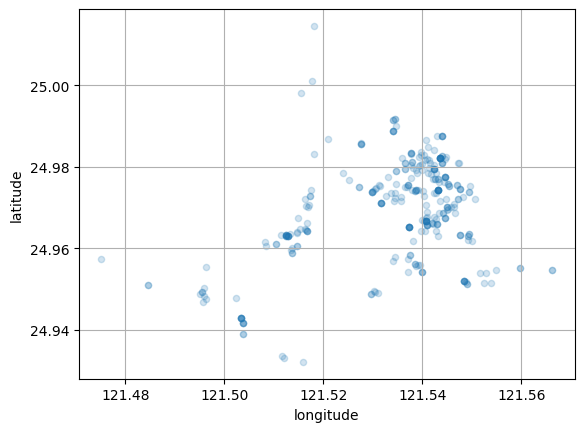

In [25]:
manual_train.plot(kind="scatter",x="longitude",y="latitude",grid=True,alpha=0.2)
plt.show()

### Look for correlations

In [26]:
corr_matric = manual_train.corr()
corr_matric['house price of unit area'].sort_values(ascending=False)

house price of unit area               1.000000
number of convenience stores           0.554251
latitude                               0.531052
longitude                              0.495413
transaction date                       0.061427
house age                             -0.214238
distance to the nearest MRT station   -0.657009
Name: house price of unit area, dtype: float64

### Transformers

Transform data to handle skewed data + Reduce the impace of outliers + Make the distribution normal

Plot the distribution to see its skewness, outliers, or non-normality

- Histogram : Shows the shape (skew,normal,uniform)
- Box plot : To detect outliers (shows median,IQR, and outliers clearly)

✅ Use StandardScaler when:

- You're using models that assume normality or optimize on gradients (e.g., linear models, logistic regression, SVM, PCA)

- Your data is approximately normal

- You want values centered around 0 and scaled by standard deviation

✅ Use MinMaxScaler when:

- You need all features to be in a specific range, like [0, 1] (often for neural networks)

- Your data is not normal, but you still need scaling

- You're visualizing or applying distance-based models where range matters

In [27]:
manual_train.columns

Index(['transaction date', 'house age', 'distance to the nearest MRT station',
       'number of convenience stores', 'latitude', 'longitude',
       'house price of unit area'],
      dtype='object')

#### transaction date

In [28]:
manual_train['transaction date']

0      2013
1      2013
2      2012
3      2013
4      2013
       ... 
326    2013
327    2013
328    2013
329    2012
330    2013
Name: transaction date, Length: 331, dtype: int32

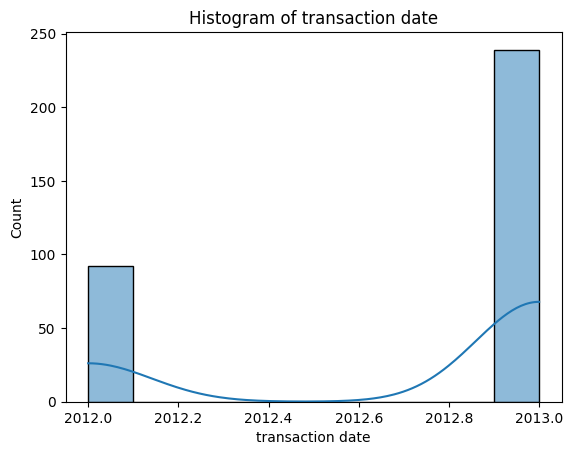

In [29]:
# Histogram

sns.histplot(manual_train['transaction date'], kde=True)
plt.title('Histogram of transaction date')
plt.show()

Histogram interpretation :
- One spike at 2012.0 and another at 2013.0
- These nothing in the middle - it looks bimodal and almost like a categorical split between two years
- This shows the dates aren't continuous over time - maybe there are transactions only at the start and end of a period.

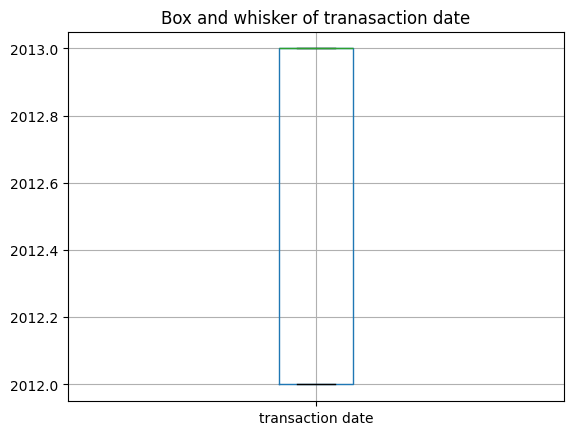

In [30]:
# Box and whisker

manual_train.boxplot(column='transaction date')
plt.title('Box and whisker of tranasaction date')
plt.show()

Box plot interpreatation :
- The box is very tall, stretching from 2012 to 2013, and theres very little detail in the quartiles, suggesting only two main groups of dates.
- It confirms that theres no smooth distribution, just a jump from one group of dates to another.

Transformer : 

- No transformers are used for dates in general because its a time based variable.
- Dates are not true numerical features — they're temporal, meaning their value is only meaningful in the context of time.

#### house age

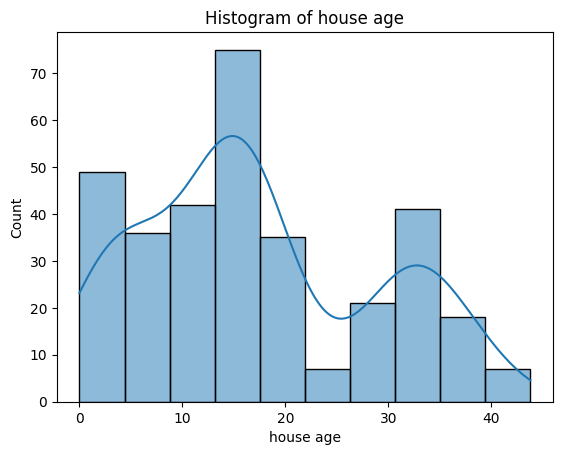

In [31]:
sns.histplot(manual_train['house age'],kde=True)
plt.title('Histogram of house age')
plt.show()

Histrogram interpretation :
- Distribution is midly skewed to the righ
- Most values are concetrated between 0 - 20, but there is a small bump around 30 - 40
- No extreme outliers

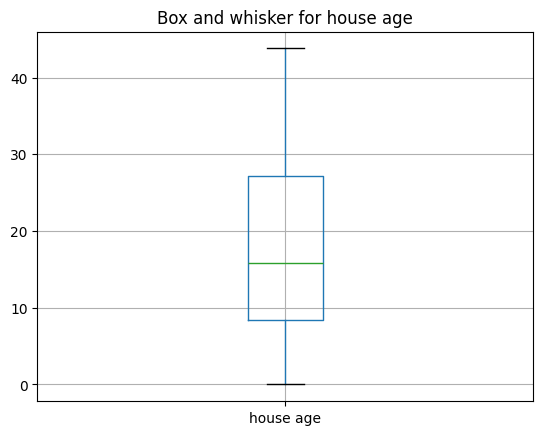

In [32]:
# Box and whisker

manual_train.boxplot(column='house age')
plt.title('Box and whisker for house age')
plt.show()

Box and whisker :
- The data is slightly skewed to the right and the tail is longer on the right.
- The medium is not exactly in the middle but more to the left.
- No outliers can be seen

Transformer :
No transformer is needed. As the data is more or less uniform.

#### distance to the nearest MRT station

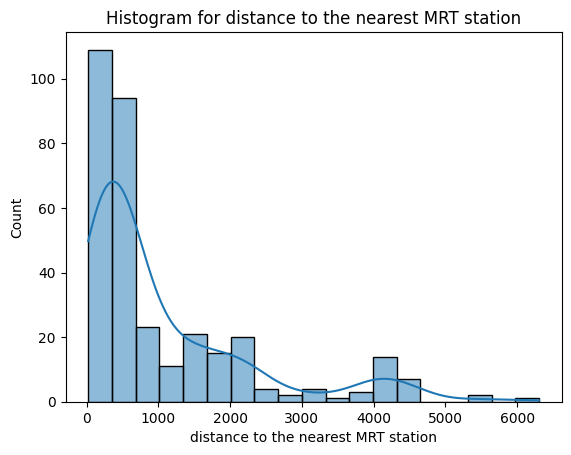

In [33]:
# Histogram

sns.histplot(manual_train["distance to the nearest MRT station"],kde=True)
plt.title("Histogram for distance to the nearest MRT station")
plt.show()

Applying the log trasnformation to see the difference

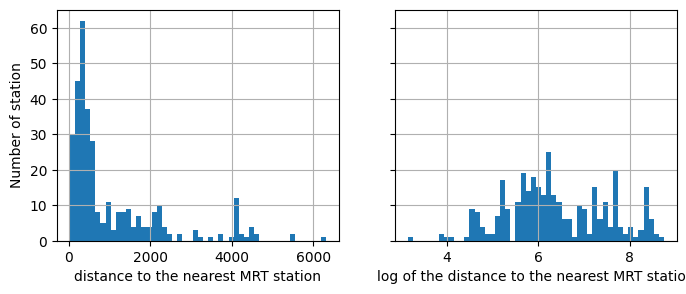

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
manual_train["distance to the nearest MRT station"].hist(ax=axs[0],bins=50)
manual_train["distance to the nearest MRT station"].apply(np.log).hist(ax=axs[1],bins=50)
axs[0].set_xlabel("distance to the nearest MRT station")
axs[1].set_xlabel("log of the distance to the nearest MRT station")
axs[0].set_ylabel("Number of station")
plt.show()

Histogram interpretation :

- The histogram clearly shows a right-skewed distribution. A large number of observations are clustered at lower distances (0-1000), and the frequency gradually decreases as the distance increases.

- There's a significant tail extending towards higher distances, indicating some properties are much further from an MRT station than the majority.

- The presence of the Kernel Density Estimate (KDE) curve further confirms this skewed shape.

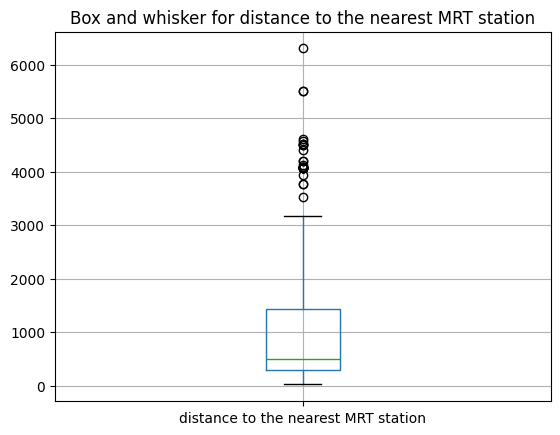

In [35]:
# Box and whisker

manual_train.boxplot(column="distance to the nearest MRT station")
plt.title("Box and whisker for distance to the nearest MRT station")
plt.show()

Box and whisker intrepretation :
- The data is highly skewed to the right 
- There are many outliers
- The median is more to the left of the box

Transformer : 
Given the rightly skewed data + outliers log transformer.

#### number of convience stores

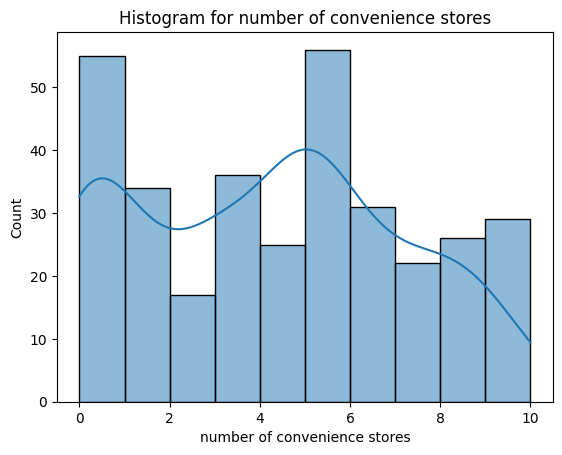

In [36]:
# Histogram

sns.histplot(manual_train["number of convenience stores"],kde=True)
plt.title("Histogram for number of convenience stores")
plt.show()

Histogram interpretation :
- There is a high count at 0, a dip, then another peak around 4-6, and then another peak at 6, followed by general decrease.
- Counts generally decrease after the peak around 6, though there are still significant counts up to 10.
- This is not a clear bell curve. Theres a noticeable frequency of properties with 0 convience stores. The distribution extends up to 10 convience stores.

A bimodal distribution is a probability distribution with two distinct peaks (or "humps") in its histogram or density plot. You’ll see this as two visible "hills" or clusters in the data when plotted.

- Unimodal = 1 peak
- Bimodal = 2 peaks
- Multimodal = 3 or more peaks

Think of "modal" as “mode” = the most frequent value or region.
So multimodal means there are multiple areas where the data tends to cluster.

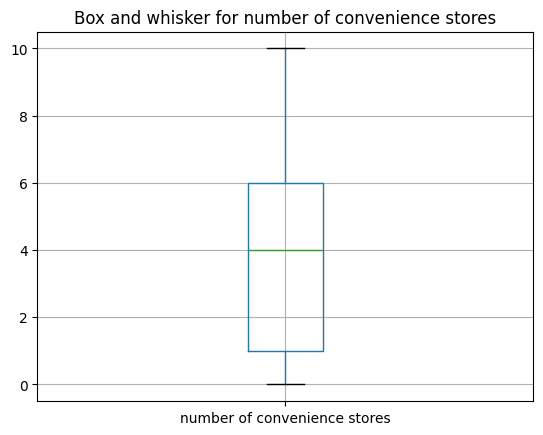

In [37]:
# box and whisker

manual_train.boxplot(column="number of convenience stores")
plt.title("Box and whisker for number of convenience stores")
plt.show()

Box and whisker intrepertation :
-  The upper whisker extends all the way to 10, and the lower whisker extends to 0. This indicates that the data is not significantly skewed in the conventional sense, especially not "rightly skewed."
- No outliers
- the median is 4. 

Transformer : 

- The histogram shows multiple peaks, suggesting a somewhat uniform or possibly bimodal distribution rather than a strongly skewed one.
- Given that the data is not significantly skewed and covers a discrete, limited range (0 to 10), a non-linear transformer (like a log transformer) is generally not needed or recommended.
- Log transformations are used to make highly skewed data more symmetrical, which isn't the primary characteristic here. Applying a log transform to data that includes 0 and is not heavily skewed can sometimes be more problematic than beneficial.

- No transformers

#### Latitude and longitude

- If no clustering or distance based tasks then apply only standardization and no custom transformer is needed.

- If you are doing clustering KNN or distance-based , don't standardize but rather use a custiner transformer to compute real geographical distances if needed.

### Feature Scaling

#### transaction date

No — you'd use standardization only if the extracted date-based feature is continuous and meaningful for that model (like time intervals). Not because it's a date.

#### house age

Standardization would be best because the data is roughly normal.

#### distance to the nearest MRT station

Feature Scaler:

- Robust Scaler (sklearn.preprocessing.RobustScaler): After applying a logarithmic transformation, the distribution will be less skewed, but outliers might still have a disproportionate effect on standard scaling methods (like StandardScaler).

- RobustScaler scales features using statistics that are robust to outliers. It scales the data according to the Interquartile Range (IQR) and median, which are less affected by extreme values than the mean and standard deviation used by StandardScaler. This is particularly beneficial given the clear outliers observed in your boxplot, even after a potential log transformation.

#### number of convience stores

- Standard Scaler

#### Latitude and longitude

- If no clustering or distance based tasks then apply only standardization and no custom transformer is needed.

- If you are doing clustering KNN or distance-based , don't standardize but rather use a custiner transformer to compute real geographical distances if needed.

### Scaling the target

- Its better when all features are on the same scale / range
- Works best for linear regression, gradient descent, etc
- Helps the model train better - learns is mde easiser for the model

In [38]:
target_variable = manual_train["house price of unit area"]
target_variable.describe()

count    331.000000
mean      38.391541
std       13.735373
min        7.600000
25%       28.250000
50%       39.300000
75%       46.600000
max      117.500000
Name: house price of unit area, dtype: float64

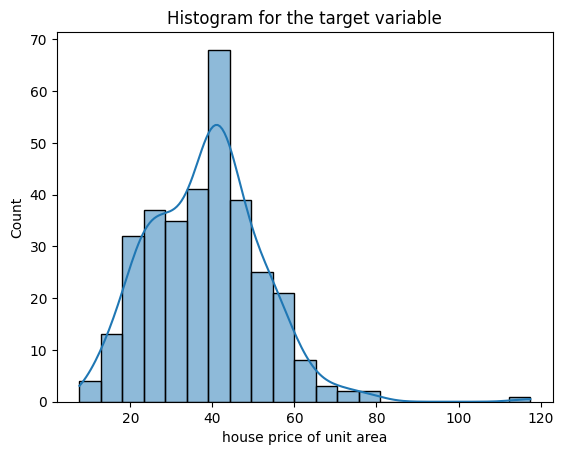

In [39]:
# histogram

sns.histplot(target_variable,kde=True)
plt.title("Histogram for the target variable")
plt.show()

In [40]:
target_variable.skew()

np.float64(0.7134898463456818)

| Skew Value   | Interpretation      | What to Do                               |
| ------------ | ------------------- | ---------------------------------------- |
| 0.0          | Perfectly symmetric | No transformation needed                 |
| 0.0 to ±0.5  | Slight skew         | Scaling usually enough                   |
| ±0.5 to ±1.0 | **Moderate skew**   | Consider `StandardScaler`, maybe try log |
| > ±1.0       | Strong skew         | Use `log1p()` or another transformation  |


In [41]:
model_manual_train = TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())

In [42]:
model_manual_train.fit(manual_train[["house price of unit area"]],target_variable)

,regressor,LinearRegression()
,transformer,StandardScaler()
,func,None
,inverse_func,None
,check_inverse,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False
,copy,True


In [43]:
some_new_data = manual_train[["house price of unit area"]].iloc[:5]
print(some_new_data)

   house price of unit area
0                      42.7
1                      23.9
2                      32.1
3                      38.3
4                      40.8


In [44]:
predictions = model_manual_train.predict(some_new_data)
print(predictions)

[42.7 23.9 32.1 38.3 40.8]


## Changes using the pipeline

The purpose of fit() and transform():

- fit() : learns what must do to the data like the changes -everything
- transform() : applys the changes that was done in the fit()
- __init__() : only use when you're passing any external parameters

In [45]:
pipe_train = train_set.copy()

In [46]:
pips = pipe_train.drop(columns=["Y house price of unit area"])

In [47]:
pips

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
192,193,2013.167,43.8,57.58945,7,24.96750,121.54069
234,235,2013.250,8.0,2216.61200,4,24.96007,121.51361
5,6,2012.667,7.1,2175.03000,3,24.96305,121.51254
45,46,2013.083,36.6,488.81930,8,24.97015,121.54494
245,246,2013.417,7.5,639.61980,5,24.97258,121.54814
...,...,...,...,...,...,...,...
71,72,2013.083,35.5,640.73910,3,24.97563,121.53715
106,107,2013.083,17.2,189.51810,8,24.97707,121.54308
270,271,2013.333,10.8,252.58220,1,24.97460,121.53046
348,349,2012.833,4.6,259.66070,6,24.97585,121.54516


### Change all column names into a uniform

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class Column_name_transformer(BaseEstimator,TransformerMixin):

    def fit(self, X, y=None):
        self.new_columns = [col[2:].lstrip() for col in X.columns]
        return self

    def transform(self, X):
        x_copy = X.copy()
        x_copy.columns = self.new_columns
        return x_copy

    def get_feature_names_out(self, input_features=None):
        return self.new_columns

In [49]:
#change_name = Column_name_transformer()
#pipe_train = change_name.fit_transform(pipe_train)
#pipe_train

### Transaction date - change to only contain the year

In [50]:
class transaction_date_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.column_name] = X[self.column_name].astype(int).round()
        return X

    def get_feature_names_out(self, input_features=None):
        # Return the same column name after transformation
        return [self.column_name]

In [51]:
#transaction_date_transform = transaction_date_transformer(column_name="transaction date")
#pipe_train['transaction date'] = transaction_date_transform.fit_transform(pipe_train)
#pipe_train

### drop columns that is not needed

In [52]:
class drop_columns_not_needed(BaseEstimator,TransformerMixin):

    def __init__(self,number_columns):
        self.number_columns=number_columns

    def fit(self,X,y=None):
        X.reset_index(drop=True,inplace=True)
        self.new_x = X.iloc[:,self.number_columns:]
        return self
    
    def transform(self,X):
        return self.new_x

In [53]:
#dropping_index_columns = drop_columns_not_needed(number_columns=1)
#pipe_train = dropping_index_columns.fit_transform(pipe_train)
#pipe_train.head()

## Preprocessing pipeline

In [54]:
log_pipeline=make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log,feature_names_out="one-to-one"),
    RobustScaler()
)

In [55]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

Call all the custom functions

In [56]:
change_name = Column_name_transformer()
transaction_date_transform = transaction_date_transformer(column_name="X1 transaction date")
dropping_index_columns = drop_columns_not_needed(number_columns=1)

In [57]:
#test_pipe = ColumnTransformer([
#    ("log", log_pipeline, ["distance to the nearest MRT station", "house price of unit area"])
#], remainder='passthrough')

#test_pipe.fit_transform(pipe_train)

In [58]:
#transaction_date = transaction_date_transformer(column_name="transaction date")

#test_pipe = ColumnTransformer([
#    ("transaction_date_transform", transaction_date, ["transaction date"])
#], remainder="passthrough")

#test_pipe.fit_transform(pipe_train)

In [59]:
#dropper = drop_columns_not_needed(number_columns=1)

#test_pipe = ColumnTransformer([
#    ("drop_index", dropper, pipe_train.columns.tolist())  # or just ["column1", "column2", ...]
#], remainder="passthrough")

#test_pipe.fit_transform(pipe_train)

## Apply the preprocessing pipeline

In [60]:
# Step 1: Drop the 'No' column
X = pipe_train.drop(columns=["No", "Y house price of unit area"])
y = pipe_train["Y house price of unit area"]

In [61]:
# Step 2: Use updated pipeline
final_pipeline = make_pipeline(
    Column_name_transformer(),
    transaction_date_transformer("transaction date"),
    ColumnTransformer([
        ("log", log_pipeline, ["distance to the nearest MRT station"]),
    ], remainder=default_num_pipeline),
    LinearRegression()
)

## Train the model

In [62]:
# Step 3: Train model
final_pipeline.fit(X, y)

,steps,"[('column_name_transformer', ...), ('transaction_date_transformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column_name,'transaction date'
,transformers,"[('log', ...)]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [63]:
# Step 4: Predict
housing_predictions = final_pipeline.predict(X)

In [64]:
# Step 5: Check first 5 predictions
print("Predictions:", housing_predictions[:5].round(1))
print("True values:", y.iloc[:5].values)

Predictions: [49.2 29.9 27.8 37.3 42.2]
True values: [42.7 23.9 32.1 38.3 40.8]


In [65]:
# Step 6: Relative Error
error_ratios = housing_predictions[:5] / y.iloc[:5].values - 1
print("Errors:", ", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

Errors: 15.2%, 25.2%, -13.5%, -2.7%, 3.5%


In [66]:
# Step 7: RMSE
lin_rmse = np.sqrt(mean_squared_error(y, housing_predictions))
print("Linear Regression RMSE:", round(lin_rmse, 2))

Linear Regression RMSE: 8.38


## Data after it went through the pipeline

In [67]:
# Fit the preprocessing pipeline (exclude model step)
preprocessor_only = make_pipeline(
    Column_name_transformer(),
    transaction_date_transformer("transaction date"),
    ColumnTransformer([
        ("log", log_pipeline, ["distance to the nearest MRT station"]),
    ], remainder=default_num_pipeline)
)

In [68]:
# Fit on X
preprocessor_only.fit(X)

,steps,"[('column_name_transformer', ...), ('transaction_date_transformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column_name,'transaction date'
,transformers,"[('log', ...)]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [69]:
# Transform X
X_prepared = preprocessor_only.transform(X)

In [70]:
# Get feature names
column_transformer = preprocessor_only.named_steps["columntransformer"]
feature_names = column_transformer.get_feature_names_out()

In [71]:
# Put into DataFrame
X_prepared_df = pd.DataFrame(X_prepared, columns=feature_names)

print("After preprocessing:")
print(X_prepared_df.head())

After preprocessing:
   log__distance to the nearest MRT station  remainder__transaction date  \
0                                 -1.335266                     0.620433   
1                                  0.936466                     0.620433   
2                                  0.924680                    -1.611777   
3                                 -0.004329                     0.620433   
4                                  0.163003                     0.620433   

   remainder__house age  remainder__number of convenience stores  \
0              2.344015                                 0.968042   
1             -0.821281                                -0.049170   
2             -0.900856                                -0.388241   
3              1.707419                                 1.307112   
4             -0.865489                                 0.289900   

   remainder__latitude  remainder__longitude  
0            -0.147066              0.455057  
1            -0.743

In [72]:
X_prepared_df.head()

,log__distance to the nearest MRT station,remainder__transaction date,remainder__house age,remainder__number of convenience stores,remainder__latitude,remainder__longitude
0,-1.335266,0.620433,2.344015,0.968042,-0.147066,0.455057
1,0.936466,0.620433,-0.821281,-0.049170,-0.743117,-1.355926
2,0.924680,-1.611777,-0.900856,-0.388241,-0.504055,-1.427483
3,-0.004329,0.620433,1.707419,1.307112,0.065523,0.739277
4,0.163003,0.620433,-0.865489,0.289900,0.260463,0.953278
